# Proyecto 03 - Series de Tiempo

## Dataset: Flujo Vehicular por Unidades de Peaje AUSA

**Recuerda descargar el dataset de [aquí](https://data.buenosaires.gob.ar/dataset/flujo-vehicular-por-unidades-peaje-ausa). Deberás descargar -  al menos para comenzar - los años 2017, 2018 y 2019.**

En este notebook te dejamos unas celdas para que puedas comenzar a trabajar con este dataset para los años 2017, 2018 y 2019. Si deseas utilizar otros años, ten en cuenta que deberás hacer el preprocesamiento correspondiente, ya que la estructura de los datos puede variar.

**Importante:** Para el proyecto, debes comenzar con los datos de la autopista Illia, pago en Efectivo.

### Exploración de datos

Dedícale un buen tiempo a hacer un Análisis Exploratorio de Datos. Elige preguntas que creas que puedas responder con este dataset. Por ejemplo, ¿Cuáles son los días y horarios de mayor tráfico? También, estudia autocorrelaciones, resampleos, etc.

#### Componentes de la serie

1. Calcula las componentes estacionales y tendencia de la serie. Interpreta los resultados, si es necesario con información auxiliar (por fuera del dataset) o elementos del dataset que no estés utilizando (por ejemplo, si la tendencia es negativa, ¿puede ser porque se migre a otras formas de pago?).
1. ¿La serie posee valores atípicos? Si es así, interpreta, si es necesario con información auxiliar. **Pista**: primer semestre 2019.

### Predicción a Futuro

Debes implementar un modelo que prediga el tráfico en la autopista Illia para el último trimestre del 2019. 

1. Haz todas las transformaciones de datos que consideres necesarias. Justifica.
1. Evalúa de forma apropiada tus resultados. Justifica la métrica elegida.
1. Elige un modelo benchmark y compara tus resultados con este modelo.
1. Optimiza los hiperparámetros de tu modelo. 
1. Intenta responder la pregunta: ¿Qué información está usando el modelo para predecir?
1. Utiliza el modelo creado para predecir el tráfico en el año 2020. ¿Cómo funciona?
1. Si lo deseas, puedes agregar información de años anteriores a 2017. ¿Mejoran los resultados?

### Para pensar, investigar y, opcionalmente, implementar
1. ¿Cómo incorporarías la información sobre tipo de vehículo, forma de pago, sentido, día de la semana, etc.? En lo que respecta a las predicciones, ¿mejoran o empeoran?
1. ¿Qué ocurre si comparas las series de tiempo entre distintas estaciones de peajes?¿Tienen el mismo comportamiento o hay alguna que sea distinta a las otras? Si es así, ¿hay información auxiliar que te ayude a explicar lo que encuentras?
1. ¿Hay algo que te gustaría investigar o probar?

### **¡Tómate tiempo para investigar y leer mucho!**

### 1. Preparación del Dataset

In [56]:
#data[data.date_check != datetime.timedelta(1)] funciona revisar para obtener fechas faltantes
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import datetime
from statsmodels.tsa.seasonal import seasonal_decompose
import sqlite3
import os
import datetime
from datetime import datetime
from datetime import timedelta
from sklearn.metrics import mean_squared_error
import xgboost as xgb
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import RandomizedSearchCV
import scipy as sp

In [57]:
data_2019 = pd.read_csv('flujo-vehicular-2019.csv', sep =',')
data_2018 = pd.read_csv('flujo-vehicular-2018.csv', sep =',')
data_2017 = pd.read_csv('flujo-vehicular-2017.csv', sep =',')
data_2016 = pd.read_csv('flujo-vehicular-2016.csv', sep =',')


In [58]:
data_2019.info()
data_2019.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 812153 entries, 0 to 812152
Data columns (total 10 columns):
 #   Column          Non-Null Count   Dtype 
---  ------          --------------   ----- 
 0   periodo         812153 non-null  int64 
 1   fecha           812153 non-null  object
 2   hora_inicio     812153 non-null  int64 
 3   hora_fin        812153 non-null  int64 
 4   dia             812153 non-null  object
 5   estacion        812153 non-null  object
 6   sentido         812153 non-null  object
 7   tipo_vehiculo   812153 non-null  object
 8   forma_pago      812153 non-null  object
 9   cantidad_pasos  812153 non-null  int64 
dtypes: int64(4), object(6)
memory usage: 62.0+ MB


,periodo,fecha,hora_inicio,hora_fin,dia,estacion,sentido,tipo_vehiculo,forma_pago,cantidad_pasos
0,2019,2019-01-01,0,1,Martes,Alberti,Centro,Liviano,NO COBRADO,22
1,2019,2019-01-01,0,1,Martes,Alberti,Centro,Liviano,TELEPASE,6
2,2019,2019-01-01,0,1,Martes,Alberti,Provincia,Liviano,NO COBRADO,53
3,2019,2019-01-01,0,1,Martes,Alberti,Provincia,Liviano,TELEPASE,18
4,2019,2019-01-01,0,1,Martes,Avellaneda,Centro,Liviano,EFECTIVO,16


In [59]:
data_2018.info()
data_2018.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1375908 entries, 0 to 1375907
Data columns (total 10 columns):
 #   Column          Non-Null Count    Dtype 
---  ------          --------------    ----- 
 0   periodo         1375908 non-null  int64 
 1   fecha           1375908 non-null  object
 2   hora_inicio     1375908 non-null  int64 
 3   hora_fin        1375908 non-null  int64 
 4   dia             1375908 non-null  object
 5   estacion        1375908 non-null  object
 6   sentido         1375908 non-null  object
 7   tipo_vehiculo   1375908 non-null  object
 8   forma_pago      1375908 non-null  object
 9   cantidad_pasos  1375908 non-null  int64 
dtypes: int64(4), object(6)
memory usage: 105.0+ MB


,periodo,fecha,hora_inicio,hora_fin,dia,estacion,sentido,tipo_vehiculo,forma_pago,cantidad_pasos
0,2018,2018-01-01,0,1,Lunes,Alberdi,Centro,Liviano,NO COBRADO,29
1,2018,2018-01-01,0,1,Lunes,Alberdi,Centro,Liviano,TELEPASE,9
2,2018,2018-01-01,1,2,Lunes,Alberdi,Centro,Liviano,NO COBRADO,73
3,2018,2018-01-01,1,2,Lunes,Alberdi,Centro,Liviano,TELEPASE,39
4,2018,2018-01-01,2,3,Lunes,Alberdi,Centro,Liviano,NO COBRADO,115


In [60]:
data_2017.info()
data_2017.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1372645 entries, 0 to 1372644
Data columns (total 10 columns):
 #   Column          Non-Null Count    Dtype 
---  ------          --------------    ----- 
 0   periodo         1372645 non-null  int64 
 1   fecha           1372645 non-null  object
 2   hora_inicio     1372645 non-null  int64 
 3   hora_fin        1372645 non-null  int64 
 4   dia             1372645 non-null  object
 5   estacion        1372645 non-null  object
 6   sentido         1372645 non-null  object
 7   tipo_vehiculo   1372645 non-null  object
 8   forma_pago      1372645 non-null  object
 9   cantidad_pasos  1372645 non-null  int64 
dtypes: int64(4), object(6)
memory usage: 104.7+ MB


,periodo,fecha,hora_inicio,hora_fin,dia,estacion,sentido,tipo_vehiculo,forma_pago,cantidad_pasos
0,2017,2017-01-01,0,1,Domingo,Alberdi,Centro,Liviano,NO COBRADO,25
1,2017,2017-01-01,0,1,Domingo,Alberdi,Centro,Liviano,TELEPASE,7
2,2017,2017-01-01,1,2,Domingo,Alberdi,Centro,Liviano,NO COBRADO,5
3,2017,2017-01-01,1,2,Domingo,Alberdi,Centro,Liviano,EFECTIVO,2
4,2017,2017-01-01,1,2,Domingo,Alberdi,Centro,Liviano,EFECTIVO,94


In [61]:
data_2016.info()
data_2016.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1379443 entries, 0 to 1379442
Data columns (total 10 columns):
 #   Column          Non-Null Count    Dtype 
---  ------          --------------    ----- 
 0   periodo         1379443 non-null  int64 
 1   fecha           1379443 non-null  object
 2   hora_inicio     1379443 non-null  int64 
 3   hora_fin        1379443 non-null  int64 
 4   dia             1379443 non-null  object
 5   estacion        1379443 non-null  object
 6   sentido         1379443 non-null  object
 7   tipo_vehiculo   1379443 non-null  object
 8   forma_pago      1379443 non-null  object
 9   cantidad_pasos  1379443 non-null  int64 
dtypes: int64(4), object(6)
memory usage: 105.2+ MB


,periodo,fecha,hora_inicio,hora_fin,dia,estacion,sentido,tipo_vehiculo,forma_pago,cantidad_pasos
0,2016,2016-01-01,0,1,Viernes,Alberdi,Centro,Liviano,NO COBRADO,32
1,2016,2016-01-01,0,1,Viernes,Alberdi,Centro,Liviano,AUPASS,9
2,2016,2016-01-01,1,2,Viernes,Alberdi,Centro,Liviano,NO COBRADO,1
3,2016,2016-01-01,1,2,Viernes,Alberdi,Centro,Liviano,EFECTIVO,4
4,2016,2016-01-01,1,2,Viernes,Alberdi,Centro,Liviano,EXENTO,3


Investiguemos que valores toman los campos **estacion, sentido, tipo_vehiculo y forma_pago**

In [62]:
print(data_2019['estacion'].unique())
print(data_2018['estacion'].unique())
print(data_2017['estacion'].unique())
print(data_2016['estacion'].unique())


['Alberti' 'Avellaneda' 'Dellepiane' 'Illia' 'Retiro' 'Salguero'
 'Sarmiento' 'PDB']
['Alberdi' 'Avellaneda' 'Dellepiane Centro' 'Dellepiane Liniers' 'Illia'
 'Retiro' 'Salguero' 'Sarmiento']
['Alberdi' 'Avellaneda' 'Dellepiane Centro' 'Dellepiane Liniers' 'Illia'
 'Retiro' 'Salguero' 'Sarmiento']
['Alberdi' 'Avellaneda' 'Dellepiane Centro' 'Dellepiane Liniers' 'Illia'
 'Retiro' 'Salguero' 'Sarmiento']


In [63]:
print(data_2019['sentido'].unique())
print(data_2018['sentido'].unique())
print(data_2017['sentido'].unique())
print(data_2016['sentido'].unique())


['Centro' 'Provincia']
['Centro' 'Provincia']
['Centro' 'Provincia']
['Centro' 'Provincia']


In [64]:
print(data_2019['tipo_vehiculo'].unique())
print(data_2018['tipo_vehiculo'].unique())
print(data_2017['tipo_vehiculo'].unique())
print(data_2016['tipo_vehiculo'].unique())

['Liviano' 'Pesado']
['Liviano' 'Pesado']
['Liviano' 'Pesado']
['Liviano' 'Pesado']


In [65]:
print(data_2019['forma_pago'].unique())
print(data_2018['forma_pago'].unique())
print(data_2017['forma_pago'].unique())
print(data_2016['forma_pago'].unique())

['NO COBRADO' 'TELEPASE' 'EFECTIVO' 'EXENTO' 'INFRACCION'
 'T. DISCAPACIDAD']
['NO COBRADO' 'TELEPASE' 'EFECTIVO' 'EXENTO' 'TARJETA DISCAPACIDAD'
 'INFRACCION']
['NO COBRADO' 'TELEPASE' 'EFECTIVO' 'TARJETA DISCAPACIDAD' 'EXENTO'
 'INFRACCION' 'MONEDERO' 'Otros']
['NO COBRADO' 'AUPASS' 'EFECTIVO' 'EXENTO' 'TARJETA DISCAPACIDAD'
 'INFRACCION' 'MONEDERO']


##### Podemos decir entonces que los años 2017, 2018 y 2019 tienen las siguientes columnas con la siguiente información:

**periodo**: año del dset 

**fecha**: año dia mes

**hora_inicio** hora de inicio de la cuenta de vehiculos (DROP)

**hora_fin** hora de fin de la cuenta de vehiculos (Vamos a usar esta para tomar la hora)

**dia**: dia de la semana 

**estacion**: estaciones de peaje, difieren levemente entre los años (Dellepiane se unifica en 2019, antes habia Dellepiane Liniers y Centro, y se agrega PDB)

**sentido**: Centro o Provincia

**tipo_vehiculo**: Liviano o Pesado

**forma_pago**: Hay varias y varian entre los años.

**cantidad_pasos**: Cantidad de vehiculos

Vamos a estar trabajando con la estación **Illia** y la forma de pago **Efectivo**


In [66]:
print("Tamaño del dataset 2016: ", data_2016.shape)
print("Tamaño del dataset 2017: ", data_2017.shape)
print("Tamaño del dataset 2018: ", data_2018.shape)
print("Tamaño del dataset 2019: ", data_2019.shape)
#Unimos los 4 datasets, podemos hacerlo asi directamente ya que tienen las mismas columnas
dataset = pd.concat([data_2019, data_2018, data_2017,data_2016])
print(dataset.head)
dataset.head()

datasetoriginal=dataset #guardamos una copia original del dataset

#Nos quedamos solamente con la estación Illia y la forma de pago Efectivo
mask = np.logical_and(dataset.estacion=='Illia', dataset.forma_pago == 'EFECTIVO')
dataset = dataset[mask]

#Quitamos las columnas que no vamos a utilizar
dataset.drop(columns = ['periodo','hora_inicio','forma_pago', 'estacion'], inplace = True)

Tamaño del dataset 2016:  (1379443, 10)
Tamaño del dataset 2017:  (1372645, 10)
Tamaño del dataset 2018:  (1375908, 10)
Tamaño del dataset 2019:  (812153, 10)
<bound method NDFrame.head of          periodo       fecha  hora_inicio  hora_fin     dia    estacion  \
0           2019  2019-01-01            0         1  Martes     Alberti   
1           2019  2019-01-01            0         1  Martes     Alberti   
2           2019  2019-01-01            0         1  Martes     Alberti   
3           2019  2019-01-01            0         1  Martes     Alberti   
4           2019  2019-01-01            0         1  Martes  Avellaneda   
...          ...         ...          ...       ...     ...         ...   
1379438     2016  2016-12-31           21        22  Sábado   Sarmiento   
1379439     2016  2016-12-31           22        23  Sábado   Sarmiento   
1379440     2016  2016-12-31           22        23  Sábado   Sarmiento   
1379441     2016  2016-12-31           23         0  Sábado  

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\frame.py:3990: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


In [67]:
#Pasamos la columna fecha a formato datetime, y le unimos la hora_fin como hora
dataset['fecha2'] = pd.to_datetime(dataset.fecha) + pd.to_timedelta(dataset.hora_fin, unit = 'h')

#Quitamos las columnas fecha y hora_fin ya que las incluimos en el campo fecha2
dataset.drop(columns=['fecha','hora_fin'], inplace = True)

dataset.head()

<ipython-input-67-023e11c6ab4d>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset['fecha2'] = pd.to_datetime(dataset.fecha) + pd.to_timedelta(dataset.hora_fin, unit = 'h')


,dia,sentido,tipo_vehiculo,cantidad_pasos,fecha2
80,Martes,Centro,Liviano,537,2019-01-01 02:00:00
86,Martes,Centro,Pesado,1,2019-01-01 02:00:00
88,Martes,Provincia,Liviano,443,2019-01-01 02:00:00
94,Martes,Provincia,Pesado,1,2019-01-01 02:00:00
149,Martes,Centro,Liviano,769,2019-01-01 03:00:00


In [68]:
#Corregimos el nombre de fecha2 a fecha
dataset.rename(columns = {'fecha2':'fecha'}, inplace = True) 
dataset.head()

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\frame.py:4125: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().rename(


,dia,sentido,tipo_vehiculo,cantidad_pasos,fecha
80,Martes,Centro,Liviano,537,2019-01-01 02:00:00
86,Martes,Centro,Pesado,1,2019-01-01 02:00:00
88,Martes,Provincia,Liviano,443,2019-01-01 02:00:00
94,Martes,Provincia,Pesado,1,2019-01-01 02:00:00
149,Martes,Centro,Liviano,769,2019-01-01 03:00:00


In [69]:
#Reordenamos el dataset por fecha
dataset.sort_values('fecha', inplace = True)
dataset.reset_index(drop=True, inplace = True)
dataset

<ipython-input-69-a287ef2e7a91>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset.sort_values('fecha', inplace = True)


,dia,sentido,tipo_vehiculo,cantidad_pasos,fecha
0,Viernes,Centro,Liviano,14,2016-01-01 00:00:00
1,Viernes,Centro,Pesado,3,2016-01-01 00:00:00
2,Viernes,Provincia,Liviano,66,2016-01-01 00:00:00
3,Viernes,Provincia,Pesado,1,2016-01-01 00:00:00
4,Viernes,Provincia,Pesado,4,2016-01-01 00:00:00
...,...,...,...,...,...
346561,Martes,Provincia,Liviano,556,2019-12-31 22:00:00
346562,Martes,Provincia,Pesado,1,2019-12-31 22:00:00
346563,Martes,Centro,Liviano,580,2019-12-31 22:00:00
346564,Martes,Centro,Liviano,214,2019-12-31 23:00:00


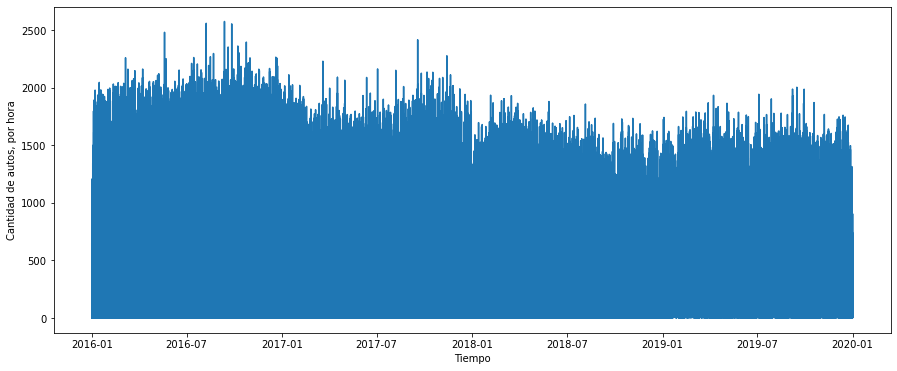

In [70]:
#Graficamos nuestros datos, tal como están
plt.figure(figsize = (15,6))
plt.plot(dataset.fecha, dataset.cantidad_pasos)
plt.xlabel('Tiempo')
plt.ylabel('Cantidad de autos, por hora')
plt.show()

In [71]:
#Resampleamos nuestros datos para agrupar por dia, y asi tal vez lograr una visualización mas amigable
diario = dataset[['cantidad_pasos','dia','fecha']].resample('D', on = 'fecha').sum()
print(diario.shape)
diario.head()

(1461, 1)


,cantidad_pasos
fecha,
2016-01-01,25602
2016-01-02,36136
2016-01-03,37225
2016-01-04,50312
2016-01-05,49907


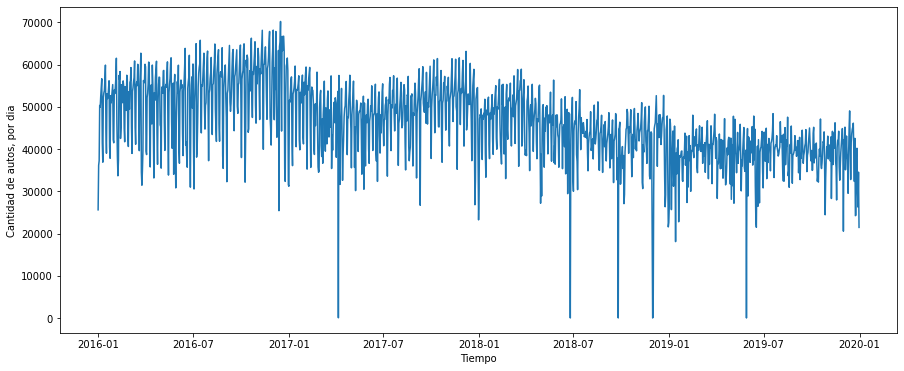

In [72]:
plt.figure(figsize = (15,6))
plt.plot(diario.index, diario.cantidad_pasos)
plt.xlabel('Tiempo')
plt.ylabel('Cantidad de autos, por dia')
plt.show()

Vemos varios días en los que no hay circulación de autos por la autopista, vamos analizar esos valores atípicos

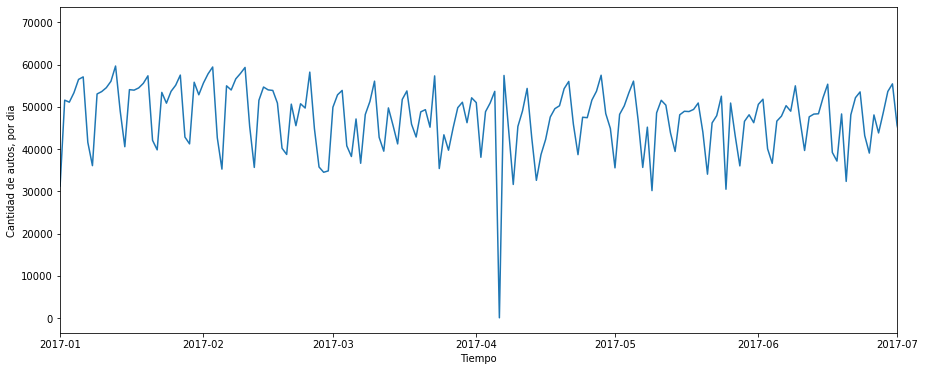

In [73]:
plt.figure(figsize = (15,6))
plt.plot(diario.index, diario.cantidad_pasos)
plt.xlabel('Tiempo')
plt.xlim(datetime(2017,1,1), datetime(2017,7,1))# editamos el límite del eje x para ver con mejor detalle los valores
plt.ylabel('Cantidad de autos, por dia')
plt.show()

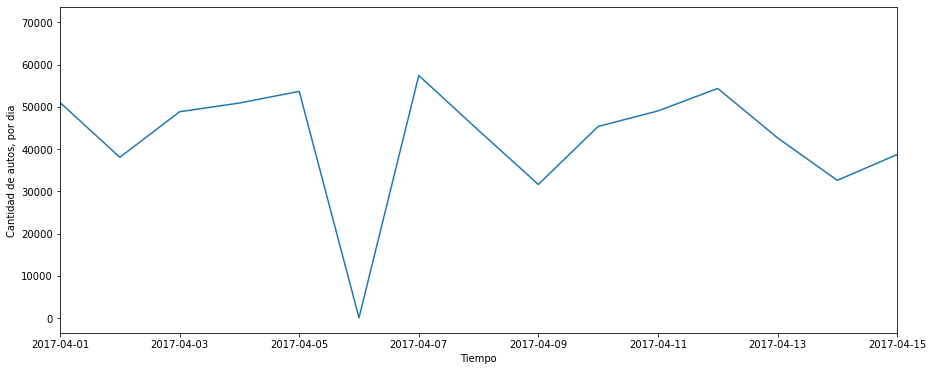

In [74]:
plt.figure(figsize = (15,6))
plt.plot(diario.index, diario.cantidad_pasos)
plt.xlabel('Tiempo')
plt.xlim(datetime(2017,4,1), datetime(2017,4,15))# analizamos lo ocurrido en la primera quincena del mes 4 
plt.ylabel('Cantidad de autos, por dia')
plt.show()

Vemos que el día 6 no hubo carga de datos aparentemente o falta ese día vamos a validar el dataset para ver que estén todos los días y los mismos contengan datos.

In [75]:
dataset.isna().sum() # vemos si tenemos algún valor faltante

dia               0
sentido           0
tipo_vehiculo     0
cantidad_pasos    0
fecha             0
dtype: int64

In [76]:
#validamos si hay días faltantes
diario['fechaNum']=diario.index.map(datetime.toordinal)
diario['difd']=0
init=0
end=len(diario.index)-1
while init!=end:
    diario.difd.iloc[init]=diario.fechaNum.iloc[init+1]-diario.fechaNum.iloc[init]
    init+=1

print(diario.query('difd>1'))

Empty DataFrame
Columns: [cantidad_pasos, fechaNum, difd]
Index: []


Vemos que no hay días faltantes, entonces obtenemos las fechas con valores atípicos para analizar a que puede corresponder.

In [77]:
diario.query('cantidad_pasos<1') # vemos cuales son los días con valores de circulación cero

,cantidad_pasos,fechaNum,difd
fecha,,,
2018-06-25,0,736870,1
2018-09-25,0,736962,1
2018-11-30,0,737028,1
2019-05-29,0,737208,1


In [78]:
#vemos que nos falta un valor del año 2017, según vimos en las gráficas anteriores.
print(diario.loc['2017-04-01':'2017-04-07']) #Vemos que pasa en el día 06/04/2017

            cantidad_pasos  fechaNum  difd
fecha                                     
2017-04-01           50995    736420     1
2017-04-02           38045    736421     1
2017-04-03           48833    736422     1
2017-04-04           50891    736423     1
2017-04-05           53655    736424     1
2017-04-06              40    736425     1
2017-04-07           57419    736426     1


Causas por la cual no hay circulación en el puesto de peajes

2017-04-06 --> Paro Nacional 

2018-06-25 --> Paro Nacional

2018-09-25 --> Paro Nacional

2018-11-30 --> G20

2019-05-29 --> Paro Nacional



Text(0.5, 1.0, 'Promedio de transito por día de la semana Año 2016 al 2019')

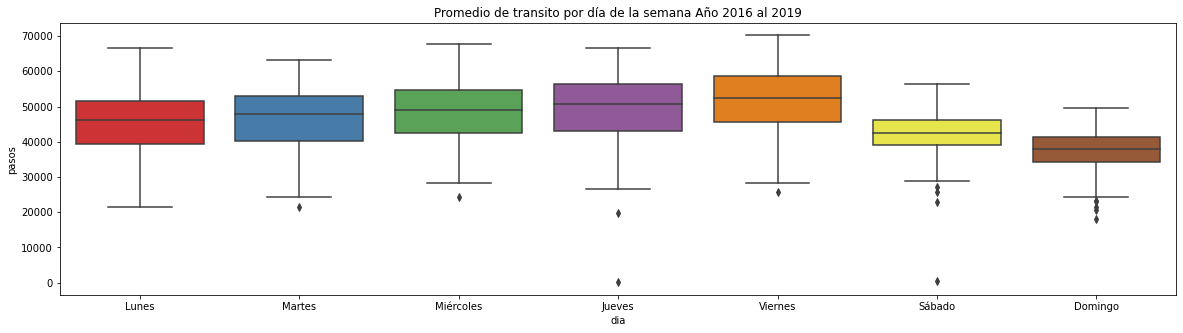

In [79]:
#Vemos como es el comportamiento de circulación por día tomando datos desde 2016 a 2019
if not os.path.isfile('peajes.db'):
    con = sqlite3.connect('peajes.db')
    datasetoriginal.to_sql('peaje',con)
else:
    con = sqlite3.connect('peajes.db')

plt.figure(figsize=(20,5))
sns.boxplot(x='dia',y='pasos',data=pd.read_sql("select dia, fecha, SUM(cantidad_pasos) as pasos from peaje where estacion='Illia' and forma_pago='EFECTIVO' group by fecha;",con),order=('Lunes','Martes','Miércoles',
'Jueves','Viernes','Sábado','Domingo'),palette="Set1")
plt.title('Promedio de transito por día de la semana Año 2016 al 2019')

Vemos la circulación va en incremento de lunes a viernes y sábado y domingo decaen.

Text(0.5, 1.0, 'Sentido con mayor circulación de vehículos por semana pago en efectivo')

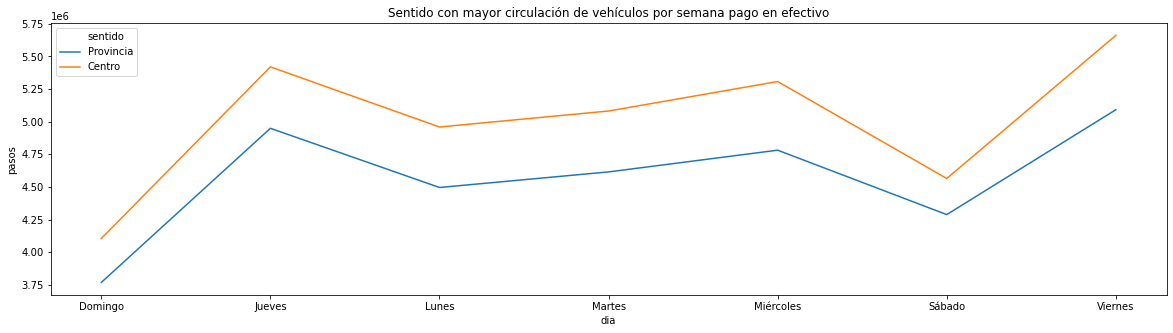

In [80]:
#vemos cual es el sentido de circulación predominante duraten el 2016 al 2019 por día de semanas
plt.figure(figsize=(20,5))
sns.lineplot(x='dia',y='pasos', data=pd.read_sql("select sentido,dia, SUM(cantidad_pasos) as pasos from peaje where estacion='Illia' and forma_pago='EFECTIVO' group by dia, sentido order by pasos asc;",con),hue='sentido')
plt.title('Sentido con mayor circulación de vehículos por semana pago en efectivo')

Con estos dos gráficos vemos que la mayor circulación de vehículos está en sentido centro siendo el día con mayor circulación la del día viernes y domingo el de menor circulación.

Text(0.5, 1.0, 'Sentido con mayor circulación de vehículos por año pago en efectivo')

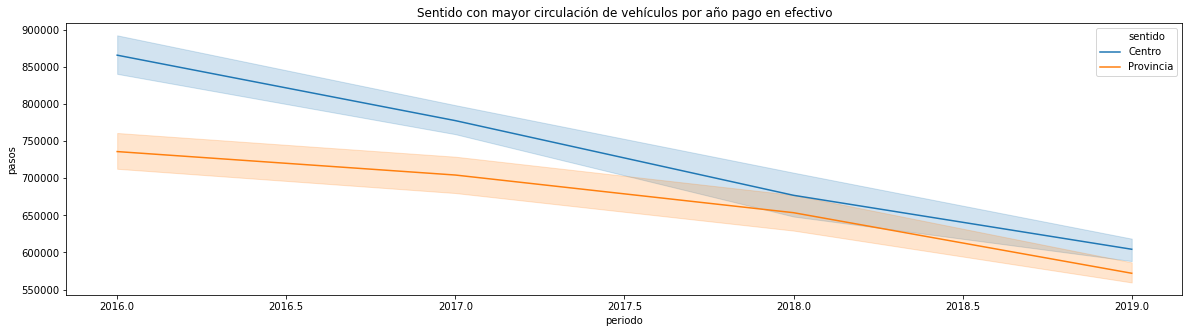

In [81]:
# Analizamos si durante los años bajo análisis se mantienen el predominio del sentido de circulación hacia el centro
plt.figure(figsize=(20,5))
sns.lineplot(x='periodo',y='pasos', data=pd.read_sql("select sentido,periodo, SUM(cantidad_pasos) as pasos, strftime('%m', fecha) as mes from peaje where estacion='Illia' and forma_pago='EFECTIVO' group by periodo,mes, sentido;",con),hue='sentido')
plt.title('Sentido con mayor circulación de vehículos por año pago en efectivo')

Vemos que la tendencia del sentido de circulación y pago en efectivo se mantiene hacia el centro y va decayendo con el pasar de los años, también se nota que en la primer mitad del año 2018 en algunos momentos vemos que es mayor el sentido de circulación hacia provincia, pero es predominante, por lo menos con la forma de pago en efectivo el sentido de circulación al centro. Se puede intuir que es una arteria de acceso a ciudad

Text(0.5, 1.0, 'Sentido con mayor circulación de vehículos por año pago metodo de pago distinto al efectivo')

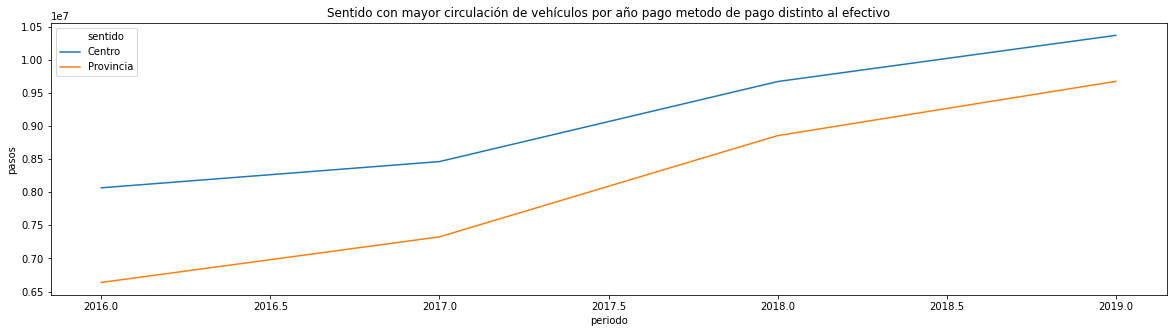

In [82]:
#analizamos el sentido de circulación por año en los otros medios de pago
plt.figure(figsize=(20,5))
sns.lineplot(x='periodo',y='pasos', data=pd.read_sql("select sentido,periodo, SUM(cantidad_pasos) as pasos from peaje where estacion='Illia' and forma_pago<>'EFECTIVO' group by periodo, sentido;",con),hue='sentido')
plt.title('Sentido con mayor circulación de vehículos por año pago metodo de pago distinto al efectivo')

Vemos que los otros medios de pago van creciendo y el sentido de circulación sigue siendo mayo con destino al centro

Text(0.5, 1.0, 'Cantidad de pases mensuales por año pago EFECTIVO')

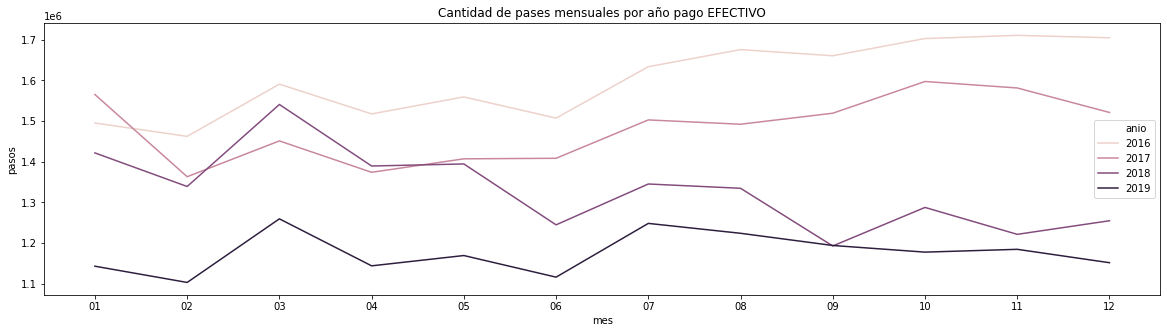

In [83]:
#Vemos por año como es el comportamiento del pago en efectivo
plt.figure(figsize=(20,5))
sns.lineplot(x='mes', y='pasos',data=pd.read_sql("SELECT strftime('%Y', fecha) as anio, strftime('%m', fecha) as mes, SUM(cantidad_pasos) as pasos from peaje  where estacion='Illia' and forma_pago='EFECTIVO' group by anio,mes;",con),hue='anio')
plt.title("Cantidad de pases mensuales por año pago EFECTIVO")

Vemos que con el pasar de los años la cantidad de pagos en efectivo va disminuyendo significativamente, seguramente si lo comparamos contra telepeaje este debería ir acrecentándose.

Text(0.5, 1.0, 'Cantidad de pases mensuales por año pago TELEPASE')

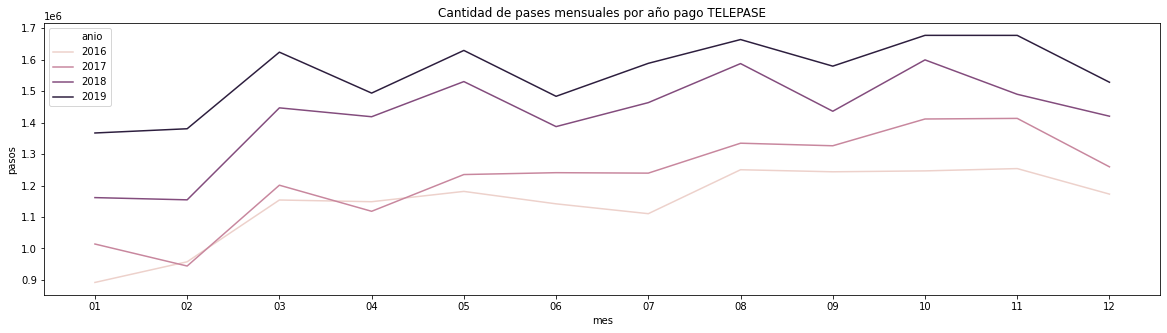

In [84]:
# Analizamos comportamiento de pago con Telepase
plt.figure(figsize=(20,5))
sns.lineplot(x='mes', y='pasos',data=pd.read_sql("SELECT strftime('%Y', fecha) as anio, strftime('%m', fecha) as mes, SUM(cantidad_pasos) as pasos from peaje  where estacion='Illia' and (forma_pago='TELEPASE' or forma_pago='AUPASS')  group by anio,mes;",con),hue='anio')
plt.title("Cantidad de pases mensuales por año pago TELEPASE")

Vemos efectivamente que la el uso de autopase o telepase se va incrementando con el pasar de los años, de hecho, para el 2020, esta autopista ya no debería aceptar medios de pago efectivo.

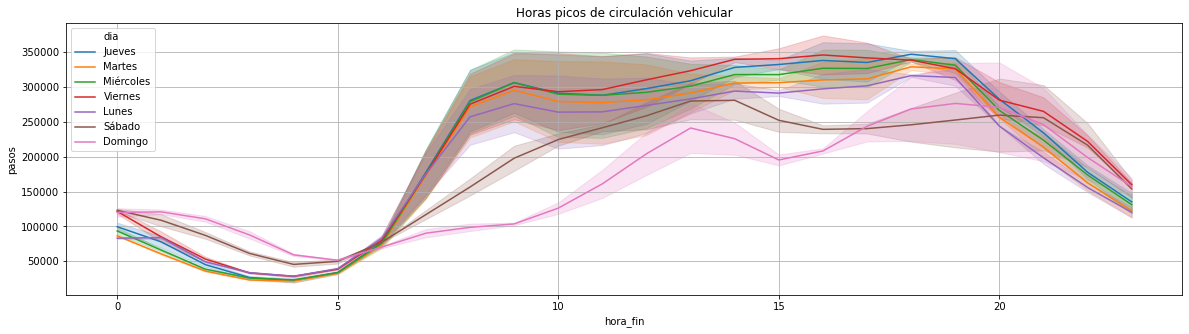

In [85]:
#Vemos promedio hora picos tomando año 2016 al 2018 diferenciando los días de la semana.
plt.figure(figsize=(20,5))
sns.lineplot(x='hora_fin', y='pasos',data=pd.read_sql("select dia,hora_fin, SUM(cantidad_pasos) as pasos from peaje where estacion='Illia' and forma_pago='EFECTIVO' group by dia,hora_fin, sentido order by pasos asc;",con),hue='dia')
plt.title("Horas picos de circulación vehicular")
plt.grid(which='both')
plt.show()

Vemos que entre las 5 y las 8 horas, empieza una curva ascendente en la circulación y a partir de las 8 hasta las 19 horas se mantiene y a partir de las 20 empieza a descender, quedando identificado que la hora pico entre las 6 y 19 horas prácticamente todos los días tiene el mismo comportamiento a nivel general, con unas variaciones bien identificables en los días sábados y domingos

Text(0.5, 1.0, 'Tendencia')

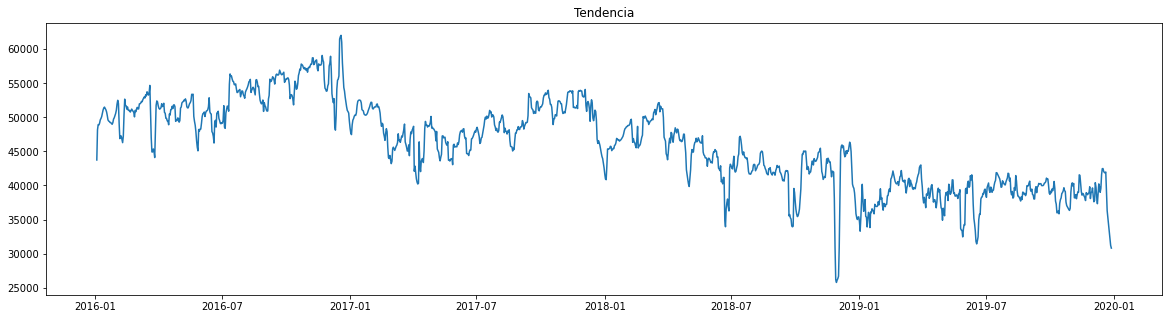

In [86]:
#Obteneos la tendencia y periodo de la serie
result = seasonal_decompose(diario.cantidad_pasos,model='additive')
plt.figure(figsize=(20,5))
plt.plot(result.trend)
plt.title('Tendencia')


Como vimos en la exploración de los datos, se valida que la tendencia en la autopista Illia con el pago en efectivo es en baja ya que se está migrando al servicio de telepase


Text(0.5, 1.0, 'Estacionalidad')

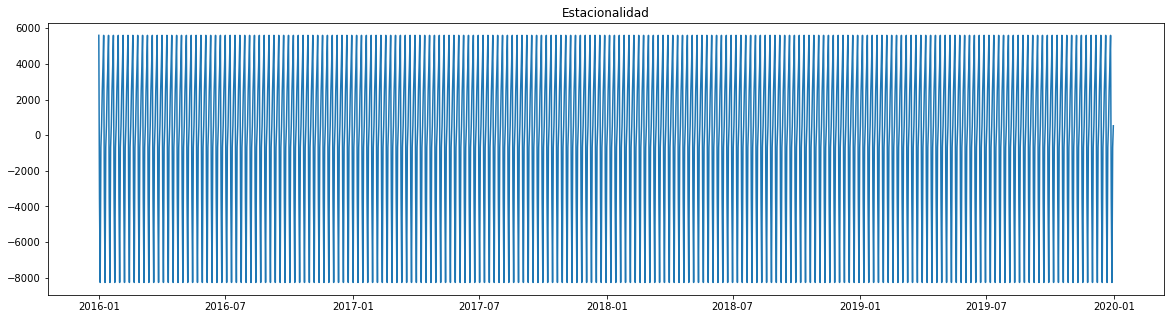

In [87]:
plt.figure(figsize=(20,5))
plt.plot(result.seasonal)
plt.title('Estacionalidad')

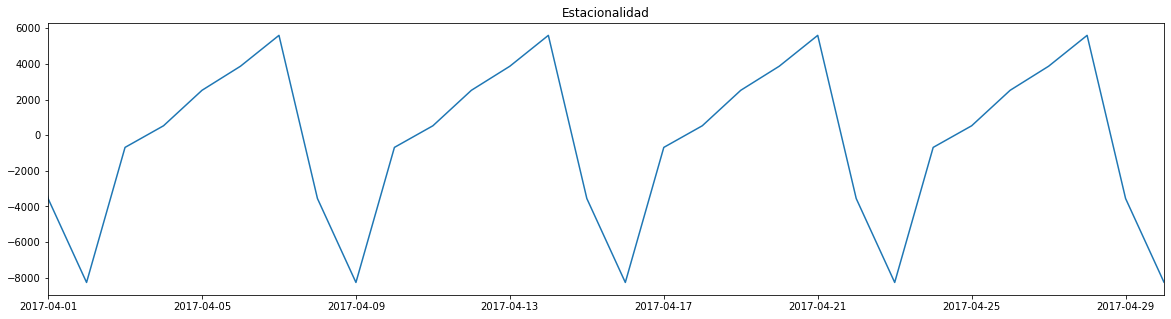

In [88]:
#hacemos zoom a la estacionalidad para ver mejor el comportamiento.
plt.figure(figsize=(20,5))
plt.plot(result.seasonal)
plt.xlim(datetime(2017,4,1), datetime(2017,4,30))
plt.title('Estacionalidad')
plt.show()

Vemos que la estacionalidad es semanal, dado que estamos analizando circulación vehicular, es razonable pensar que en los diferentes días de las semanas el comportamiento sea similar, salvo excepciones como pueden ser un feriado o paros u otros eventos excepcionales.

Armamos modelo de Benchmark

In [89]:
#Obtenemos la circulación diaria del año 2019
data2019=data=pd.read_sql("select fecha, SUM(cantidad_pasos) as pasos from peaje where estacion='Illia' and forma_pago='EFECTIVO' and (fecha between '2019-01-01' and '2019-12-31')group by fecha order by fecha asc;",con)
data2019

,fecha,pasos
0,2019-01-01,27038
1,2019-01-02,47080
2,2019-01-03,46194
3,2019-01-04,42887
4,2019-01-05,25650
...,...,...
359,2019-12-27,40182
360,2019-12-28,30681
361,2019-12-29,26259
362,2019-12-30,34523


Error del modelo en cantidad de pasadas: 6949


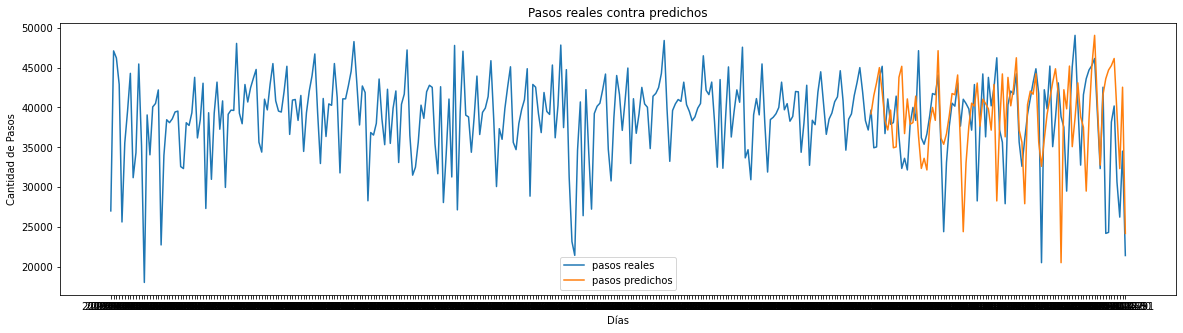

In [90]:
#Predecimos con los datos de una semana, la cantidad de pasos para la semana proxima
fechatodate=datetime.strptime('2019-10-01', '%Y-%m-%d')
fecha=fechatodate.strftime('%Y-%m-%d')
listafecha=[]
listapasos=[]
while fecha<='2019-12-31':
    mascara=data2019.fecha==(fechatodate-timedelta(days=7)).strftime('%Y-%m-%d')
    listapasos.append(int(data2019[mascara].pasos.values))
    listafecha.append(fecha)
    fecha=(datetime.strptime(fecha,'%Y-%m-%d')+timedelta(days=1)).strftime('%Y-%m-%d')
    fechatodate=fechatodate+timedelta(days=1)
dicpre={'fecha':listafecha, 'pasos':listapasos}
benchmarck=pd.DataFrame(dicpre)
benchmarck
y_pred=benchmarck.pasos
y=data=pd.read_sql("select SUM(cantidad_pasos) as pasos from peaje where estacion='Illia' and forma_pago='EFECTIVO' and (fecha between '2019-10-01' and '2019-12-31')group by fecha order by fecha asc;",con)
plt.figure(figsize=(20,5))
sns.lineplot(x='fecha',y='pasos',data=data2019, label='pasos reales')
sns.lineplot(x='fecha',y='pasos',data=benchmarck, label='pasos predichos')

plt.legend()
plt.xlabel('Días')
plt.ylabel('Cantidad de Pasos')
plt.title('Pasos reales contra predichos')
print("Error del modelo en cantidad de pasadas:",int(np.sqrt(mean_squared_error(y,y_pred)))) #Utilizamos RMSE para trabajar con la unidad de cantidad pasos y evaluar el modelo segun error en la predicción
lmod=['Benchmark']
lcp=[int(np.sqrt(mean_squared_error(y,y_pred)))]

In [91]:
diario['fecha']=pd.to_datetime(diario.index, format='%Y-%m-%d')
diario

,cantidad_pasos,fechaNum,difd,fecha
fecha,,,,
2016-01-01,25602,735964,1,2016-01-01
2016-01-02,36136,735965,1,2016-01-02
2016-01-03,37225,735966,1,2016-01-03
2016-01-04,50312,735967,1,2016-01-04
2016-01-05,49907,735968,1,2016-01-05
...,...,...,...,...
2019-12-27,40182,737420,1,2019-12-27
2019-12-28,30681,737421,1,2019-12-28
2019-12-29,26259,737422,1,2019-12-29


Empezamos a procesar el dataset, para armar un modelo para predecir la cantidad de pasadas para el último trimestre del año 2019, al dataset le vamos a incorporar la información de los días de las semana, por la estacionalidad de la serie, el mes, días del mes y feriados que son valores descriptivos de las serie por año y una variable particular que describe los eventos donde encontramos datos con registros menores a 40 pasadas por días que son los valores atípicos detectados.

In [92]:
df=pd.read_sql("select fecha , dia as dias, SUM(cantidad_pasos) as pasos from peaje where estacion='Illia' and forma_pago='EFECTIVO' and (fecha between '2017-01-01' and '2019-31-12')group by fecha order by fecha asc;",con)
#AL pasar de SQL a pandas, por algún motivo estos registros no los trasnfiere, por lo cual se cargan nuevamente a mano
df=df.append({'fecha':'2018-06-25','dias':'Lunes','pasos':0},ignore_index=True)
df=df.append({'fecha':'2018-09-25','dias':'Martes','pasos':0},ignore_index=True)
df=df.append({'fecha':'2018-11-30','dias':'Viernes','pasos':0},ignore_index=True)
df=df.append({'fecha':'2019-05-29','dias':'Miércoles','pasos':0},ignore_index=True)
df.sort_values('fecha', inplace = True)
df.reset_index(drop=True, inplace = True)
df['fecha'] = pd.to_datetime(df.fecha, format='%Y-%m-%d')
df['anio'] = df['fecha'].dt.year # extraemos el año
df['mes'] = df['fecha'].dt.month # Extraemos el número del mes
df['diasn'] = df['fecha'].dt.day # extraemos días del mes
df=pd.get_dummies(df) #convertimos las variables categóricas de los días de las semanas
y=df[['pasos','fecha']] # separo los valores a predecir
X=df.drop(['pasos'],axis=1) # separo las variables predictoras generadas
X=X.set_index('fecha')
y=y.set_index('fecha')
import holidays
#cargamos los feriados
X['feriados']=0
import holidays
for date, name in sorted(holidays.AR(years=[2017,2018,2019]).items()):
        X.loc[date,'feriados']=1

#creamos una variable que indique eventos fuera de lo comun
X['eventosImprevistos']=0
eventosImprevistos=['2017-04-06','2018-06-25','2018-09-25','2018-11-30','2019-05-29']
for item in eventosImprevistos:
    X.loc[item,'eventosImprevistos']=1
    
#separamos en train y test
X_train=X.loc['2017-01-01':'2018-12-31']
X_test=X.loc['2019-01-01':'2019-09-30']
y_train=y.loc['2017-01-01':'2018-12-31']
y_test=y.loc['2019-01-01':'2019-09-30']
X_3trim=X.loc['2019-10-01':'2019-12-31']
y_3trim=y.loc['2019-10-01':'2019-12-31']

In [93]:
# Entrenamos un modelo xgboots para con hiperparámetros bases
data_dmatrix = xgb.DMatrix(data=X_train,label=y_train)
xg_reg = xgb.XGBRegressor( objective ='reg:squarederror',
                max_depth = 2, n_estimators = 100,verbosity=1)
xg_reg.fit(X_train,y_train)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.300000012, max_delta_step=0, max_depth=2,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=100, n_jobs=0, num_parallel_tree=1, random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
             tree_method='exact', validate_parameters=1, verbosity=1)

El error en entrenamiento es:  3564


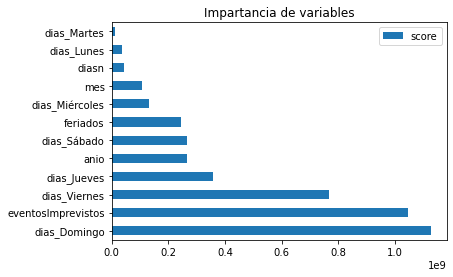

In [94]:
y_train_pred=xg_reg.predict(X_train)
print('El error en entrenamiento es: ',int(np.sqrt(mean_squared_error(y_train,y_train_pred))))
feature_important = xg_reg.get_booster().get_score(importance_type='gain')
keys = list(feature_important.keys())
values = list(feature_important.values())
grapimp = pd.DataFrame(data=values, index=keys, columns=["score"]).sort_values(by = "score", ascending=False)
grapimp.plot(kind='barh')
plt.title('Impartancia de variables')
lmod.append('Entrenamiento Split ene 2017 a dic 2018')
lcp.append(int(np.sqrt(mean_squared_error(y_train,y_train_pred))))

El gráfico anterior muestra cuales son las variables predictoras y la importancia que cada una tiene en el modelo para predecir.

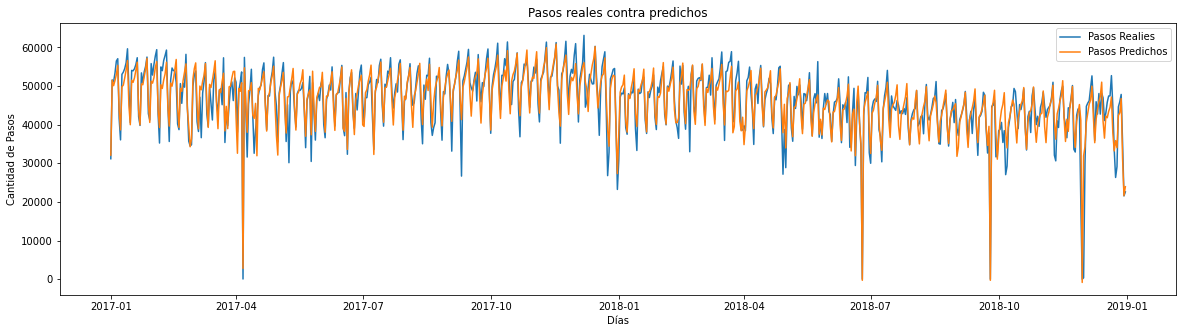

In [95]:
def graficar(ejex,ejey,ejeypred):
    plt.figure(figsize=(20,5))
    sns.lineplot(x=ejex.index,y=ejey.pasos.values,label='Pasos Realies')
    sns.lineplot(x=ejex.index,y=ejeypred, label='Pasos Predichos')
    plt.legend()
    plt.xlabel('Días')
    plt.ylabel('Cantidad de Pasos')
    plt.title('Pasos reales contra predichos')
    plt.show
graficar(X_train,y_train,y_train_pred)

A simple vista parece que las serie predicha se amolda bastante bien a la serie real y vemos que el error es bástate bajo en relación al benchmark

El error en test es: 8241


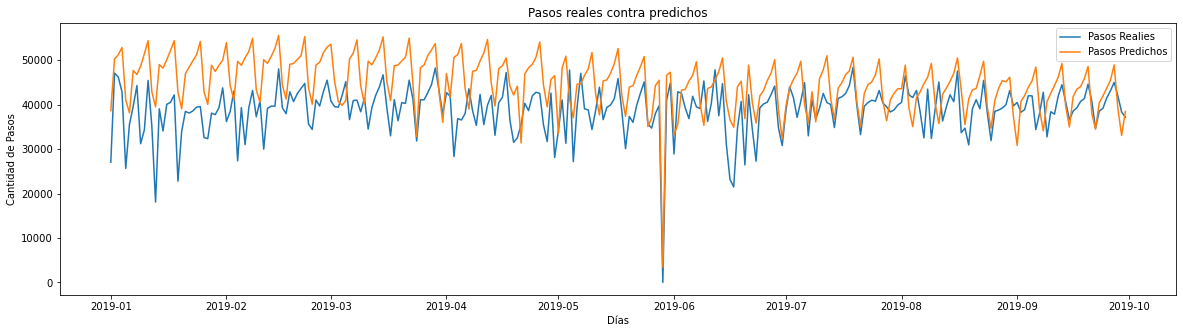

In [96]:
y_test_pred=xg_reg.predict(X_test)
print('El error en test es:',int(np.sqrt(mean_squared_error(y_test,y_test_pred))))
graficar(X_test,y_test,y_test_pred)
lmod.append('test Split ene 2017 a dic 2018')
lcp.append(int(np.sqrt(mean_squared_error(y_test,y_test_pred))))

Vemos que en test el error es bastante mayor al benchmark, estamos haciendo overfiting, vamos a rearmar el dataset del traing  y test para que tenga datos del 2019 y ver si mejor la predicción

In [97]:
X_train=X.loc['2017-01-01':'2019-05-31']
X_test=X.loc['2019-06-01':'2019-09-30']
y_train=y.loc['2017-01-01':'2019-05-31']
y_test=y.loc['2019-06-01':'2019-09-30']
data_dmatrix = xgb.DMatrix(data=X_train,label=y_train)
xg_reg = xgb.XGBRegressor( objective ='reg:squarederror',
                max_depth = 3, n_estimators = 100,verbosity=1)
xg_reg.fit(X_train,y_train)
y_train_pred=xg_reg.predict(X_train)
print('El error train es:' ,int(np.sqrt(mean_squared_error(y_train,y_train_pred))))
lmod.append('entrenamiento Split ene 2017 a may 2019')
lcp.append(int(np.sqrt(mean_squared_error(y_train,y_train_pred))))

El error train es: 3043


El error en test es : 4720


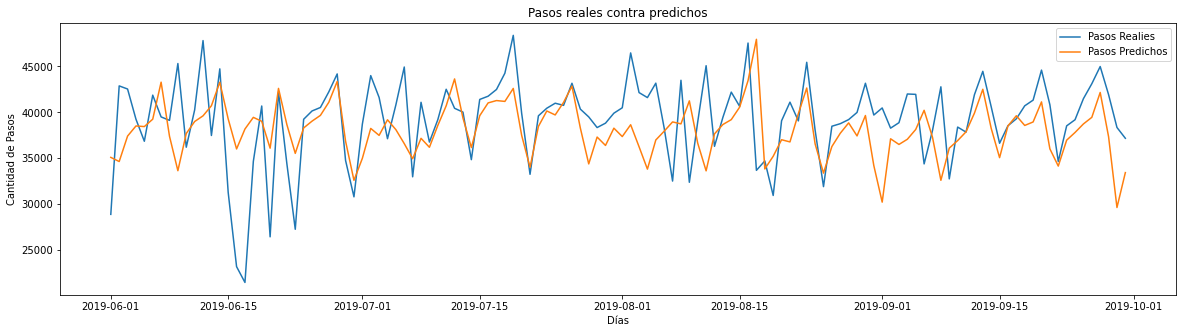

In [98]:
y_test_pred=xg_reg.predict(X_test)
print('El error en test es :',int(np.sqrt(mean_squared_error(y_test,y_test_pred))))
graficar(X_test,y_test,y_test_pred)
lmod.append('test Split ene 2017 a may 2019')
lcp.append(int(np.sqrt(mean_squared_error(y_test,y_test_pred))))

Vemos que el modelo, al seleccionar mejor los datos de entrenamiento y testing, mejora bastante bien en relación al primer split realizado y con relación al benchmark. hora vamos a predecir el último trimestre del 2019

El Error en la predicción es de : 5442


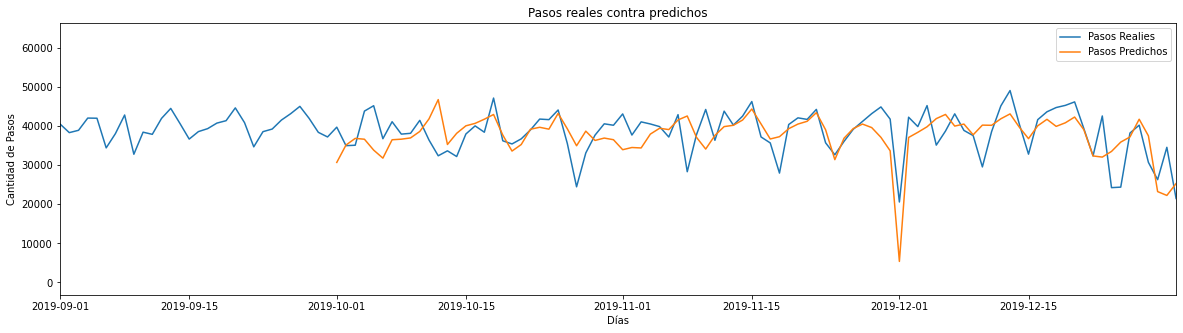

In [99]:
y_3trim_pred=xg_reg.predict(X_3trim)
print('El Error en la predicción es de :',int(np.sqrt(mean_squared_error(y_3trim,y_3trim_pred))))
plt.figure(figsize=(20,5))
sns.lineplot(x=X.index,y=y.pasos.values,label='Pasos Realies')
sns.lineplot(x=X_3trim.index,y=y_3trim_pred, label='Pasos Predichos')
plt.xlim(datetime(2019,9,1), datetime(2019,12,31))
plt.legend()
plt.xlabel('Días')
plt.ylabel('Cantidad de Pasos')
plt.title('Pasos reales contra predichos')
plt.show
lmod.append('Predicción último trimestre 2019')
lcp.append(int(np.sqrt(mean_squared_error(y_3trim,y_3trim_pred))))

Vemos que el modelo tiene un error menor al benchmark, mejora aproximadamente en un 20% ahora vamos a ver si podemos optimizar los hiperparámetros para disminuir el error.

In [100]:
param_dist ={'booster':['gbtree'],
             'max_depth':sp.stats.randint(1, 30),
             'n_estimators':sp.stats.randint(1, 100),'n_jobs':sp.stats.randint(1, 4),
             'objective':['reg:squarederror'],
             'subsample':[0.5,0.75,1]}

modelxg=RandomizedSearchCV(xg_reg,param_dist,random_state=42,n_iter=50,cv=5)
modelxg.fit(X_train,y_train)

RandomizedSearchCV(cv=5,
                   estimator=XGBRegressor(base_score=0.5, booster='gbtree',
                                          colsample_bylevel=1,
                                          colsample_bynode=1,
                                          colsample_bytree=1, gamma=0,
                                          gpu_id=-1, importance_type='gain',
                                          interaction_constraints='',
                                          learning_rate=0.300000012,
                                          max_delta_step=0, max_depth=3,
                                          min_child_weight=1, missing=nan,
                                          monotone_constraints='()',
                                          n_estimators=100, n_jobs=0,
                                          num_par...
                   param_distributions={'booster': ['gbtree'],
                                        'max_depth': <scipy.stats._distn_infrastruct

El Error en la predicción es de: 5077


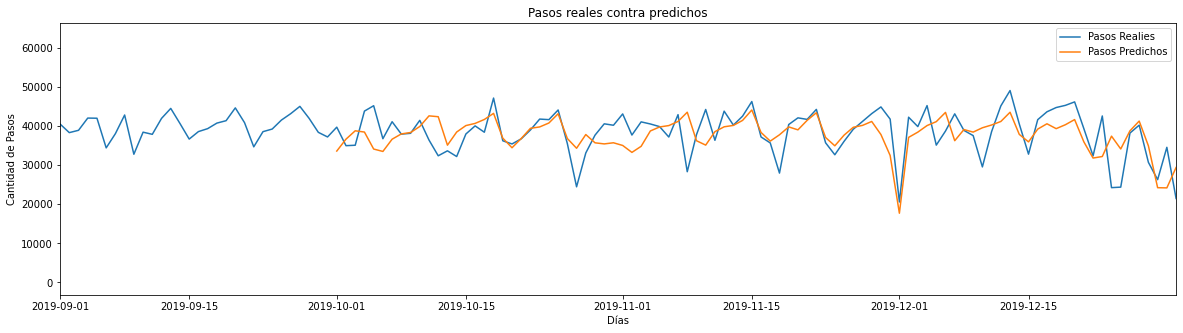

In [101]:
y_3trim_pred=modelxg.predict(X_3trim)
print('El Error en la predicción es de:',int(np.sqrt(mean_squared_error(y_3trim,y_3trim_pred))))
plt.figure(figsize=(20,5))
sns.lineplot(x=X.index,y=y.pasos.values,label='Pasos Realies')
sns.lineplot(x=X_3trim.index,y=y_3trim_pred, label='Pasos Predichos')
plt.xlim(datetime(2019,9,1), datetime(2019,12,31))
plt.legend()
plt.xlabel('Días')
plt.ylabel('Cantidad de Pasos')
plt.title('Pasos reales contra predichos')
plt.show
lmod.append('Predicción último trimestre 2019 optimizado')
lcp.append(int(np.sqrt(mean_squared_error(y_3trim,y_3trim_pred))))

Optimizamos hiper parámetrso utilizando random search y vemos que el modelo sigue mejorando

Agregamos información del 2016 pare ver si mejora el modelo

In [102]:
X_train=X.loc['2016-01-01':'2019-05-31']
X_test=X.loc['2019-06-01':'2019-09-30']
y_train=y.loc['2016-01-01':'2019-05-31']
y_test=y.loc['2019-06-01':'2019-09-30']
X_3trim=X.loc['2019-10-01':'2019-12-31']
y_3trim=y.loc['2019-10-01':'2019-12-31']

In [103]:
modelxg.fit(X_train,y_train)

RandomizedSearchCV(cv=5,
                   estimator=XGBRegressor(base_score=0.5, booster='gbtree',
                                          colsample_bylevel=1,
                                          colsample_bynode=1,
                                          colsample_bytree=1, gamma=0,
                                          gpu_id=-1, importance_type='gain',
                                          interaction_constraints='',
                                          learning_rate=0.300000012,
                                          max_delta_step=0, max_depth=3,
                                          min_child_weight=1, missing=nan,
                                          monotone_constraints='()',
                                          n_estimators=100, n_jobs=0,
                                          num_par...
                   param_distributions={'booster': ['gbtree'],
                                        'max_depth': <scipy.stats._distn_infrastruct

El Error en la predicción es de : 5077


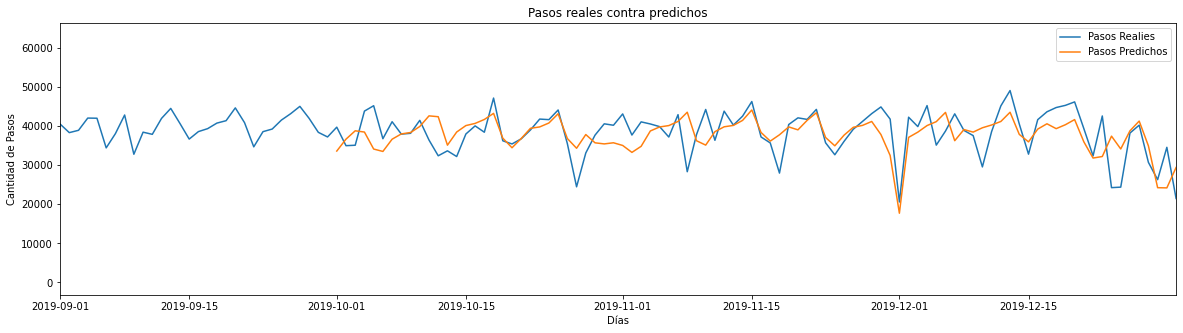

In [104]:
y_3trim_pred=modelxg.predict(X_3trim)
print('El Error en la predicción es de :',int(np.sqrt(mean_squared_error(y_3trim,y_3trim_pred))))
plt.figure(figsize=(20,5))
sns.lineplot(x=X.index,y=y.pasos.values,label='Pasos Realies')
sns.lineplot(x=X_3trim.index,y=y_3trim_pred, label='Pasos Predichos')
plt.xlim(datetime(2019,9,1), datetime(2019,12,31))
plt.legend()
plt.xlabel('Días')
plt.ylabel('Cantidad de Pasos')
plt.title('Pasos reales contra predichos')
plt.show
lmod.append('Predicción último trimestre 2019 optimizado + año 2016')
lcp.append(int(np.sqrt(mean_squared_error(y_3trim,y_3trim_pred))))

In [110]:
#armamos el dataset a predecir dataset del año 2020
fecha2020=datetime.strptime('2020-01-01', '%Y-%m-%d')
wfecha2020=fecha2020.strftime('%Y-%m-%d')
lfecha=[]
ldias=[]
iter=3
while wfecha2020 <= '2020-12-31':
    lfecha.append(fecha2020)
    if iter==1:
        ldias.append('Lunes')
    elif iter==2:
        ldias.append('Martes')
    elif iter==3:
        ldias.append('Miércoles')
    elif iter==4:
        ldias.append('Jueves')
    elif iter==5:
        ldias.append('Viernes')
    elif iter==6:
        ldias.append('Sábado')
    else:
        ldias.append('Domingo')
        iter=0
    iter+=1
    fecha2020=fecha2020+timedelta(days=1)
    wfecha2020=fecha2020.strftime('%Y-%m-%d')

dic={'fecha':lfecha,'dias':ldias}
anio2020=pd.DataFrame(dic)
anio2020['anio']=anio2020['fecha'].dt.year
anio2020['mes']=anio2020['fecha'].dt.month
anio2020['diasn']=anio2020['fecha'].dt.day
anio2020=pd.get_dummies(anio2020)
anio2020=anio2020.set_index('fecha')
anio2020['feriados']=0
for date, name in sorted(holidays.AR(years=[2020]).items()):
        anio2020.loc[date,'feriados']=1
anio2020['eventosImprevistos']=0
dic={'Modelo':lmod,'RMSE':lcp}
experimentos=pd.DataFrame(dic)
experimentos.sort_values('RMSE', inplace = True)
experimentos.reset_index(drop=True, inplace = True)
experimentos

,Modelo,RMSE
0,entrenamiento Split ene 2017 a may 2019,3043
1,Entrenamiento Split ene 2017 a dic 2018,3564
2,test Split ene 2017 a may 2019,4720
3,Predicción último trimestre 2019 optimizado,5077
4,Predicción último trimestre 2019 optimizado + ...,5077
5,Predicción último trimestre 2019,5442
6,Benchmark,6949
7,test Split ene 2017 a dic 2018,8241


In [106]:
y2020_pred=modelxg.predict(anio2020)# obtenemos la predicción para el año 2020

<function matplotlib.pyplot.show(*args, **kw)>

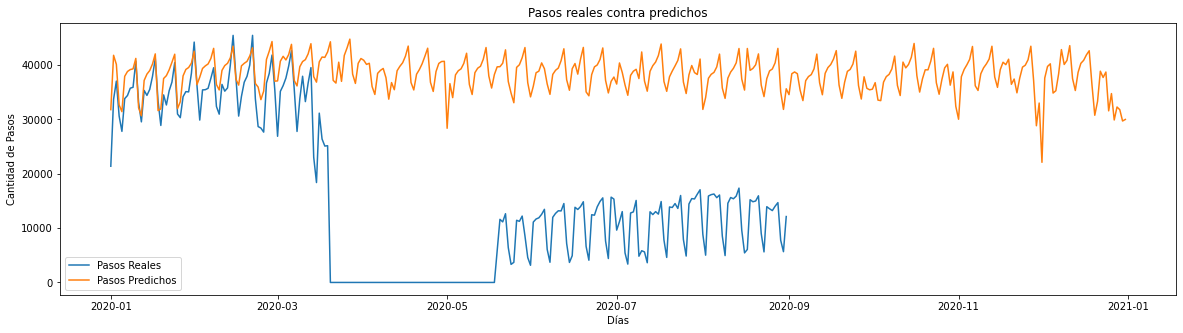

In [107]:
#ahora exportamos el dataset del año 2020 y graficamos una serie sobre la otra
dataset2020=pd.read_csv('flujo-vehicular-2020.csv', sep =',')


mask = np.logical_and(dataset2020.estacion=='ILLIA', dataset2020.forma_pago == 'Efectivo')
dataset2020 = dataset2020[mask]
#Quitamos las columnas que no vamos a utilizar
dataset2020.drop(columns = ['periodo','hora_inicio','forma_pago', 'estacion'], inplace = True)
dataset2020['fecha2'] = pd.to_datetime(dataset2020.fecha) + pd.to_timedelta(dataset2020.hora_fin, unit = 'h')
#Quitamos las columnas fecha y hora_fin ya que las incluimos en el campo fecha2
dataset2020.drop(columns=['fecha','hora_fin'], inplace = True)

dataset2020.rename(columns = {'fecha2':'fecha'}, inplace = True)
dataset2020.sort_values('fecha', inplace = True)
dataset2020.reset_index(drop=True, inplace = True)

diario2020 = dataset2020[['cantidad_pasos','dia','fecha']].resample('D', on = 'fecha').sum()

plt.figure(figsize=(20,5))
sns.lineplot(x=diario2020.index,y=diario2020.cantidad_pasos,label='Pasos Reales')
sns.lineplot(x=anio2020.index,y=y2020_pred, label='Pasos Predichos')
#plt.xlim(datetime(2019,9,1), datetime(2019,12,31))
plt.legend()
plt.xlabel('Días')
plt.ylabel('Cantidad de Pasos')
plt.title('Pasos reales contra predichos')
plt.show

Como vemos en la gráfica el tráfico Por autopista Illia pago efectivo, el modelo se aproxima durante los primeros tres meses, luego por efecto de la pandemia vemos la diferencia.

¿Cómo incorporarías la información sobre tipo de vehículo, forma de pago, sentido, día de la semana, etc.? las variables las agregaría como categorías con get_dummies.


¿Qué ocurre si comparas las series de tiempo entre distintas estaciones de peajes?
Entiendo que el comportamiento sería totalmente distinto
¿Tienen el mismo comportamiento o hay alguna que sea distinta a las otras? Puedo intuir que el comportamiento va ser ditinto sobre todo en la forma de pago, ya que Illia está en un proceso de solo poder utilizar telepase.
Si es así, ¿hay información auxiliar que te ayude a explicar lo que encuentras? Búsqueda en google y ultimas noticias sobre la autopista inteligente y los cambias ya definidos para automatizar 100% las cabinas del peaje Illia.

¿Hay algo que te gustaría investigar o probar? Ver el nivel de fraude y como mejora o no con la automatización del puesto de peaje